In [14]:
import numpy as np
from matplotlib import pyplot as plt

In [15]:
from power_models import PowerSource, PowerLoad, PowerBus, PowerGrid

Параметры графиков.

In [16]:
user_figsize = (12, 3*4)
user_fontsize = 14

In [17]:
seed = 1991
rng = np.random.default_rng(seed)

# Bus.
Ubus_nom = 48.0
Ubus_init = 0.95*Ubus_nom
beta_bus = 0.01e-3/(6*6*1800e-6) # dt/C

# Sources.
N_SOURCE = 5
Usource_init_min, Usource_init_max = [0.10*Ubus_nom, 0.95*Ubus_nom]
Rdroop_min, Rdroop_max = [2e-3, 20e-3]
beta_source_min, beta_source_max = [0.8, 0.9]
Uref_rnd_min, Uref_rnd_max = [0.95*Ubus_nom, 1.05*Ubus_nom]

Usource_init_set = rng.uniform(Usource_init_min, Usource_init_max, size=N_SOURCE)
Rdroop_set = rng.uniform(Rdroop_min, Rdroop_max, size=N_SOURCE)
beta_source_set = rng.uniform(beta_source_min, beta_source_max, size=N_SOURCE)
Uref_set = rng.uniform(Uref_rnd_min, Uref_rnd_max, size=N_SOURCE)

# Loads.
N_LOAD = 10
Prnd_min, Prnd_max = [10.0, 8.5e3]
beta_load_min, beta_load_max = [0.1, 0.9]

Pload_set = rng.uniform(Prnd_min, Prnd_max, size=N_LOAD)
Uload_nom_set = np.full_like(Pload_set, Ubus_nom)
Iload_init_set = np.full_like(Pload_set, 0.0)
beta_load_set = rng.uniform(beta_load_min, beta_load_max, size=N_LOAD)

print(f'Мощность номинальная системы электроснабжения: {np.sum(Pload_set):.2f}')

Мощность номинальная системы электроснабжения: 36069.81


In [18]:
bus = PowerBus(
    Uinit = Ubus_init,
    beta = beta_bus
    )

sources = [
    PowerSource(
        Rdroop = Rdroop_set[idx],
        Uinit = Usource_init_set[idx],
        beta = beta_source_set[idx]
        ) for idx in range(N_SOURCE)
]

loads = [
    PowerLoad(
        Unom = Uload_nom_set[idx],
        beta = beta_load_set[idx]
        ) for idx in range(N_LOAD)
]

## Симуляция

In [19]:
N_STEPS = 200

In [20]:
source_currents = np.zeros((N_STEPS, N_SOURCE))
source_voltages = np.zeros((N_STEPS, N_SOURCE))
load_currents = np.zeros((N_STEPS, N_LOAD))
bus_voltage = np.zeros(N_STEPS)

for n in range(N_STEPS):
    if n == 0:
        IU_source = [
            source.step(
                u = Ubus_init,
                Uref = Uref_set[idx]
                ) for idx, source in enumerate(sources)]
        load_currents[n] = [
            load.step(
                u = Ubus_init,
                P = Pload_set[idx]
                ) for idx, load in enumerate(loads)]
    else:
        IU_source = [
            source.step(
                u = bus_voltage[n-1],
                Uref = Uref_set[idx]
                ) for idx, source in enumerate(sources)]
        load_currents[n] = [
            load.step(
                u = bus_voltage[n-1],
                P = Pload_set[idx]
                ) for idx, load in enumerate(loads)]
    for idx, (I, U) in enumerate(IU_source):
        source_currents[n,idx] = I
        source_voltages[n,idx] = U
    bus_voltage[n] = bus.step(source_currents[n].sum() - load_currents[n].sum())
        

Через класс микрогрида.

In [21]:
microgrid = PowerGrid(
    N_SOURCE = N_SOURCE,
    N_LOAD = N_LOAD,
    Rdroop_set = Rdroop_set,
    Ubus_init = Ubus_init,
    Usource_init_set = Usource_init_set,
    Uload_nom_set = Uload_nom_set,
    Iload_init_set =Iload_init_set,
    beta_bus = beta_bus,
    beta_source_set = beta_source_set,
    beta_load_set = beta_load_set
)

In [22]:
trans_vals, _, _, _ = microgrid.step(
    N_STEPS = N_STEPS,
    Uref_set = Uref_set,
    Pload_set = Pload_set)

[Vbus, Is, Vs, Il] = trans_vals

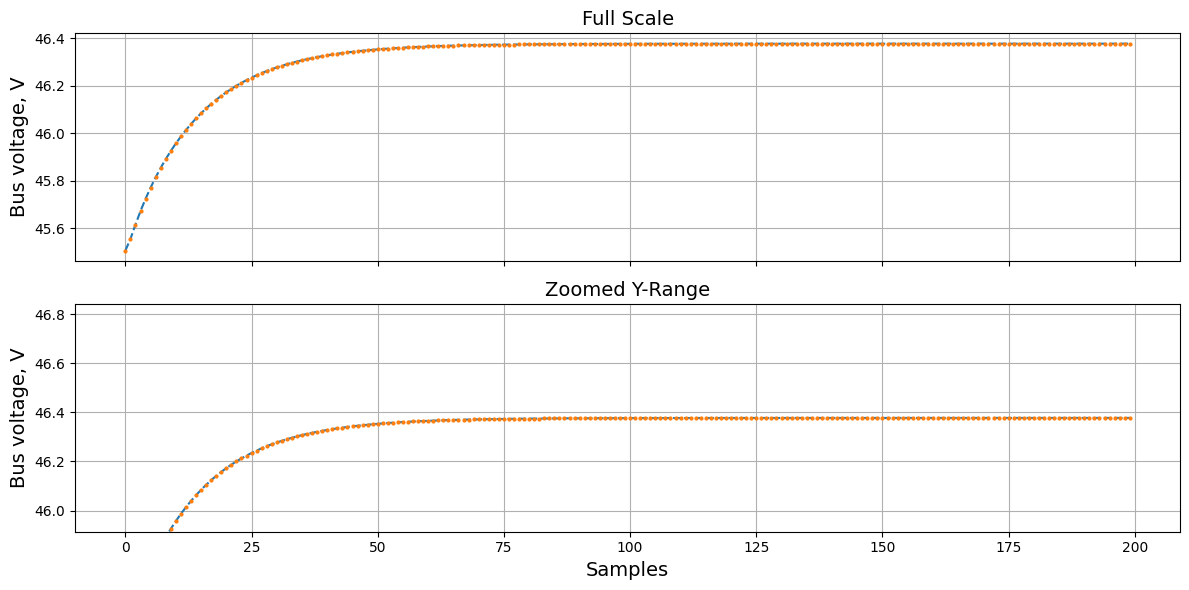

In [23]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Full-scale plot
ax1.plot(bus_voltage, '--')
ax1.plot(Vbus, 'o', markersize=2, linestyle='')
ax1.set_ylabel('Bus voltage, V', fontsize=user_fontsize)
ax1.set_title('Full Scale', fontsize=user_fontsize)
ax1.grid(True)

# Zoomed y-range plot
ax2.plot(bus_voltage, '--')
ax2.plot(Vbus, 'o', markersize=2, linestyle='')
ax2.set_xlabel('Samples', fontsize=user_fontsize)
ax2.set_ylabel('Bus voltage, V', fontsize=user_fontsize)
ax2.set_title('Zoomed Y-Range', fontsize=user_fontsize)
ax2.grid(True)

# Set narrow y-limits (adjust ymin and ymax based on your data!)
ymin, ymax = Vbus[-1]*0.99, Vbus[-1]*1.01
ax2.set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()

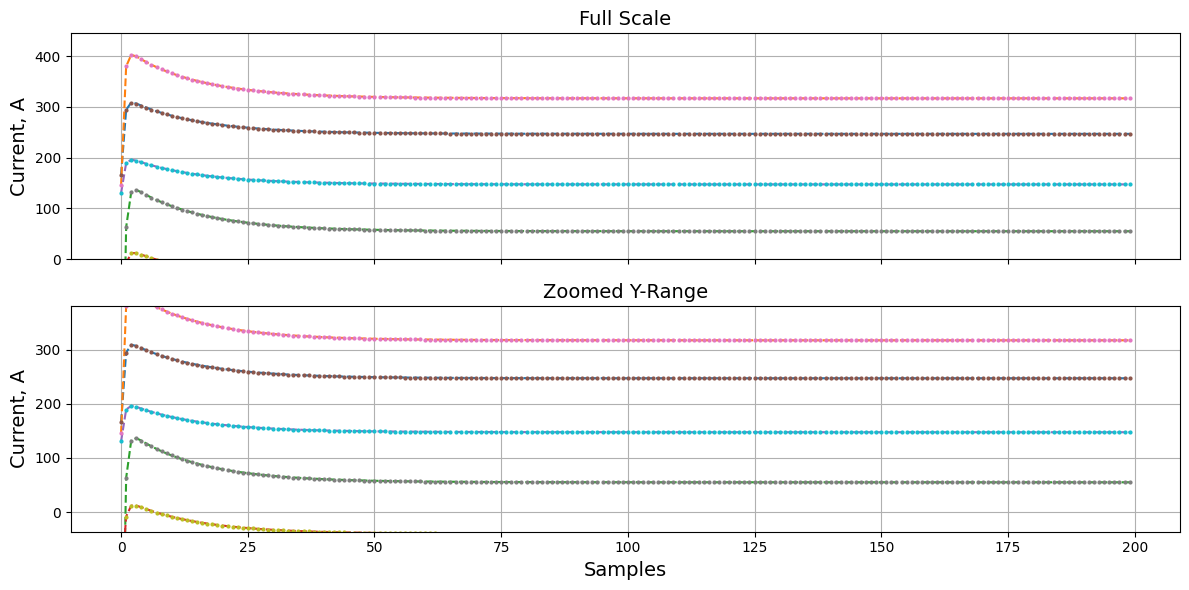

In [24]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Full-scale plot
ax1.plot(source_currents, '--')
ax1.plot(Is, 'o', markersize=2, linestyle='')
ax1.set_ylabel('Current, A', fontsize=user_fontsize)
ax1.set_title('Full Scale', fontsize=user_fontsize)
ax1.grid(True)
ax1.set_ylim(bottom=0)

# Zoomed y-range plot
ax2.plot(source_currents, '--')
ax2.plot(Is, 'o', markersize=2, linestyle='')
ax2.set_xlabel('Samples', fontsize=user_fontsize)
ax2.set_ylabel('Current, A', fontsize=user_fontsize)
ax2.set_title('Zoomed Y-Range', fontsize=user_fontsize)
ax2.grid(True)

# Set narrow y-limits (adjust ymin and ymax based on your data!)
ymin, ymax = Is[-1].min()*0.9, Is[-1].max()*1.2
ax2.set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()

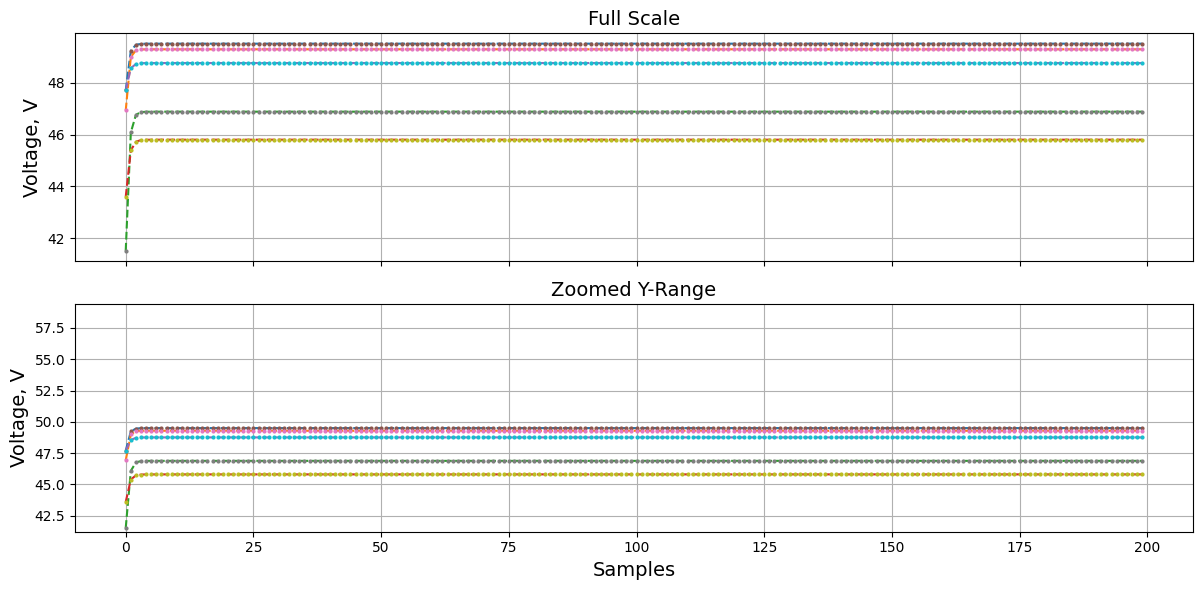

In [25]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Full-scale plot
ax1.plot(source_voltages, '--')
ax1.plot(Vs, 'o', markersize=2, linestyle='')
ax1.set_ylabel('Voltage, V', fontsize=user_fontsize)
ax1.set_title('Full Scale', fontsize=user_fontsize)
ax1.grid(True)

# Zoomed y-range plot
ax2.plot(source_voltages, '--')
ax2.plot(Vs, 'o', markersize=2, linestyle='')
ax2.set_xlabel('Samples', fontsize=user_fontsize)
ax2.set_ylabel('Voltage, V', fontsize=user_fontsize)
ax2.set_title('Zoomed Y-Range', fontsize=user_fontsize)
ax2.grid(True)

# Set narrow y-limits (adjust ymin and ymax based on your data!)
ymin, ymax = Vs[-1].min()*0.9, Vs[-1].max()*1.2
ax2.set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()

## Работа с переменной нагрузкой

In [ ]:
N_TRAIN = 10
seed_generator = rng.integers(0, 2**32, size=N_TRAIN, dtype=np.uint32)

In [27]:
bus_voltage = []
for m in range(N_TRAIN):
    load_random = np.random.default_rng(seed_generator[m])
    
    Pload_set = load_random.uniform(Prnd_min, Prnd_max, size=N_LOAD)
    beta_load_set = load_random.uniform(beta_load_min, beta_load_max, size=N_LOAD)
    trans_vals, steady_vals, agent_states, global_state = microgrid.step(
        N_STEPS = N_STEPS,
        Uref_set = Uref_set,
        Pload_set = Pload_set)
    
    bus_voltage.extend(trans_vals[0])
    
    print(f'Мощность системы электроснабжения: {np.sum(Pload_set):.2f}')
    print(f'Напряжение на шине, В:, {steady_vals[0]:.2f}')
    print(f'Токи источников, А:', np.round(steady_vals[1],2))
    print(f'Напряжения источников, В:', np.round(steady_vals[2],2))
    for idx, agent in enumerate(agent_states):
        print(f'Состояния агента {idx}:', np.round(agent, 2))
    print(f'Состояние микрогрида:', np.round(global_state,2))


Мощность системы электроснабжения: 46727.27
Напряжение на шине, В:, 45.90
Токи источников, А: [284.7  369.1  107.13  -6.97 176.94]
Напряжения источников, В: [49.5  49.28 46.88 45.8  48.75]
Состояния агента 0: [284.7  176.94 369.1   49.5   48.75  49.28]
Состояния агента 1: [369.1  284.7  107.13  49.28  49.5   46.88]
Состояния агента 2: [107.13 369.1   -6.97  46.88  49.28  45.8 ]
Состояния агента 3: [ -6.97 107.13 176.94  45.8   46.88  48.75]
Состояния агента 4: [176.94  -6.97 284.7   48.75  45.8   49.5 ]
Состояние микрогрида: [284.7  369.1  107.13  -6.97 176.94  49.5   49.28  46.88  45.8   48.75]
Мощность системы электроснабжения: 42607.91
Напряжение на шине, В:, 46.08
Токи источников, А: [270.21 349.11  87.1  -19.77 165.58]
Напряжения источников, В: [49.5  49.28 46.88 45.8  48.75]
Состояния агента 0: [270.21 165.58 349.11  49.5   48.75  49.28]
Состояния агента 1: [349.11 270.21  87.1   49.28  49.5   46.88]
Состояния агента 2: [ 87.1  349.11 -19.77  46.88  49.28  45.8 ]
Состояния агента

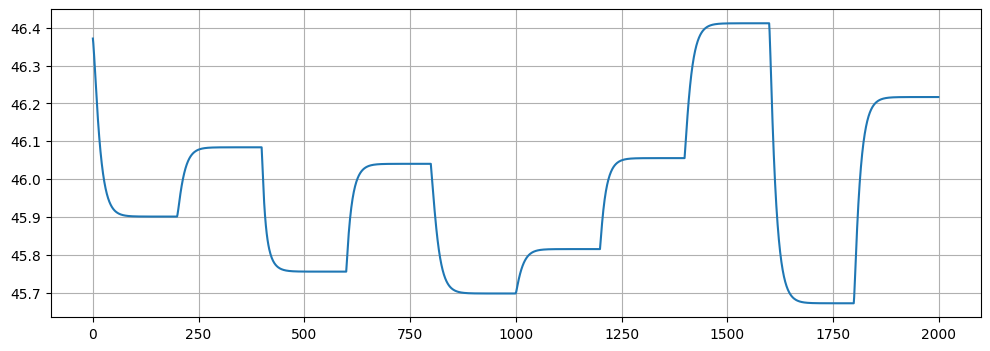

In [28]:
plt.figure(figsize=(12,4))
plt.plot(bus_voltage)
plt.grid()
plt.show()